<a href="https://colab.research.google.com/github/efrsw/hsebio-hw3/blob/naive-bayes/hsebio_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Загрузка данных

Гайд по скачиванию:
https://www.metagenomics.wiki/tools/fastq/ncbi-ftp-genome-download

In [1]:
import gzip

!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz'
!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz'

!gunzip GCF_000355675.1_ASM35567v1_genomic.fna.gz
!gunzip GCF_000355675.1_ASM35567v1_genomic.gbff.gz

--2022-10-20 09:03:24--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.228, 130.14.250.12, 2607:f220:41e:250::13, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1168222 (1.1M) [application/x-gzip]
Saving to: ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’

GCF_000355675.1_ASM 100%[===================>]   1.11M  1.02MB/s    in 1.1s    

2022-10-20 09:03:26 (1.02 MB/s) - ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’ saved [1168222/1168222]

--2022-10-20 09:03:26--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.228, 130.14.250.12, 2607:f220:41e:250::13, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nl

### Reading sequences

In [2]:
!pip install bio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 270 kB 4.5 MB/s 
     |████████████████████████████████| 2.6 MB 36.3 MB/s 


In [3]:
from Bio import SeqIO
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

seq = None
gb = None

# считываем скачанные файлы
for record in SeqIO.parse("/content/GCF_000355675.1_ASM35567v1_genomic.fna", "fasta"):
    seq = record.seq

for record in SeqIO.parse('/content/GCF_000355675.1_ASM35567v1_genomic.gbff', 'genbank'):
  gb = record

In [4]:
start, end = gb.features[0].location.start, None

ncod = []
cod = []

# записываем кодирующие и некодирующие последовательности
for i in range(len(gb.features)):
  feature = gb.features[i]
  fseq = feature.extract(seq)

  end = feature.location.start

  if feature.type == 'CDS' and fseq[:3] == 'ATG' and len(fseq) % 3 == 0:
    cod.append(fseq.__str__())

    if len(seq[start:end]) != 0:
      ncod.append(seq[start:end].__str__())

    start = feature.location.end

### Initial probabilities

In [7]:
def seq_probs(seq):
  return np.array([
      seq.count('T'), seq.count('C'), 
      seq.count('A'), seq.count('G')
    ]) / len(seq)

def cod_probs(seq):
  res = []
  for i in range(3):
    res.append(seq_probs(seq[i::3]))
  return np.array(res)

def make_table1(cod_seqs, ncod_seqs):
  table1 = pd.DataFrame(np.vstack((cod_probs(''.join(cod_seqs)), seq_probs(''.join(ncod_seqs)))).T, 
                       index=['T', 'C', 'A', 'G'], 
                       columns=[f'pos{i}' for i in range(1, 4)] + ['nc'])
  return table1

In [8]:
t1 = make_table1(cod, ncod)
t1

,pos1,pos2,pos3,nc
T,0.181203,0.296080,0.314970,0.272901
C,0.206748,0.226955,0.233379,0.228714
A,0.256854,0.302191,0.238267,0.276767
G,0.355196,0.174773,0.213384,0.221619


### Transition probabilities

In [9]:
def cod_dprobs(seqs):
  dcounts = dict(
    zip([1, 2, 3], 
        [dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                  [0] * 16)) for i in range(3)])
    )
  for seq in seqs:
    for i in range(1, len(seq)):
      dcounts[i % 3 + 1][seq[i-1:i+1]] += 1
  return get_probs(dcounts)

def ncod_dprobs(seqs):
    dcounts =dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                    [0] * 16))
    for seq in seqs:
      for i in range(1, len(seq)):
        dcounts[seq[i-1:i+1]] += 1
        
    return get_probs({0: dcounts})[0]

def get_probs(dcounts):
  for pos in dcounts:
    nuc_groups = dict(zip('TCAG', [0] * 4))
    for dup in dcounts[pos]:
      nuc_groups[dup[0]] += dcounts[pos][dup]
    for dup in dcounts[pos]:
      dcounts[pos][dup] /= nuc_groups[dup[0]]
  return dcounts

def make_table2(cod_seqs, ncod_seqs):
  table2 = pd.DataFrame(cod_dprobs(cod_seqs))
  table2[4] = pd.Series(ncod_dprobs(ncod_seqs))
  table2.rename(columns=dict(zip(np.arange(1, 5), 
                                 [f'pos{i}' for i in range(1, 4)] + ['nc'])),
                inplace=True)
  table2.index = [prob_notation(idx) for idx in table2.index.values]
  return table2

def prob_notation(st):
  return st[1] + '|' + st[0]

In [10]:
t2 = make_table2(cod, ncod)
t2

,pos1,pos2,pos3,nc
T|T,0.185541,0.498016,0.316087,0.318294
C|T,0.189713,0.199146,0.180139,0.208396
A|T,0.249076,0.172641,0.221208,0.244180
G|T,0.375670,0.130197,0.282566,0.229130
T|C,0.185250,0.248514,0.269667,0.252617
C|C,0.156196,0.198164,0.244435,0.213797
A|C,0.276236,0.315008,0.244359,0.286844
G|C,0.382318,0.238314,0.241540,0.246742
T|A,0.180048,0.334056,0.307936,0.269508
C|A,0.194071,0.213889,0.193709,0.205264


### Prediction

In [20]:
def cod_proba(seq, t1, t2, frame=1):
  
  if len(seq) == 0:
    print('No sequence')
    return None
  
  if frame not in [1, 2, 3]:
    print('No such frame')
    return None

  prev_nuc = seq[0]
  start_pos = None
  if frame == 1: log_prob = np.log(t1['pos1'][prev_nuc]); start_pos = 1
  elif frame == 2: log_prob = np.log(t1['pos3'][prev_nuc]); start_pos = 0
  elif frame == 3: log_prob = np.log(t1['pos2'][prev_nuc]); start_pos = 2

  for i, nuc in enumerate(seq[1:], start_pos):
    pos = 'pos{}'.format(i % 3 + 1)
    pair = '{}|{}'.format(nuc, prev_nuc)
    log_prob += np.log(t2[pos][pair])
    prev_nuc = nuc
  return np.exp(log_prob)

def ncod_proba(seq, t1, t2):
  if len(seq) == 0:
    print('No sequence')
    return None
  prev_nuc = seq[0]
  log_prob = np.log(t1['nc'][prev_nuc])
  for i, nuc in enumerate(seq[1:], 1):
    pair = '{}|{}'.format(nuc, prev_nuc)
    log_prob += np.log(t2['nc'][pair])
    prev_nuc = nuc
  return np.exp(log_prob)

def get_cod_probs(seq, t1, t2):
  prob1 = cod_proba(seq, t1, t2)
  prob2 = cod_proba(seq[1:] + seq[:1], t1, t2)
  prob3 = cod_proba(seq[2:] + seq[:2], t1, t2)
  probnc = ncod_proba(seq, t1, t2)
  return np.array([prob1, prob2, prob3] / (prob1 + prob2 + prob3 + probnc))

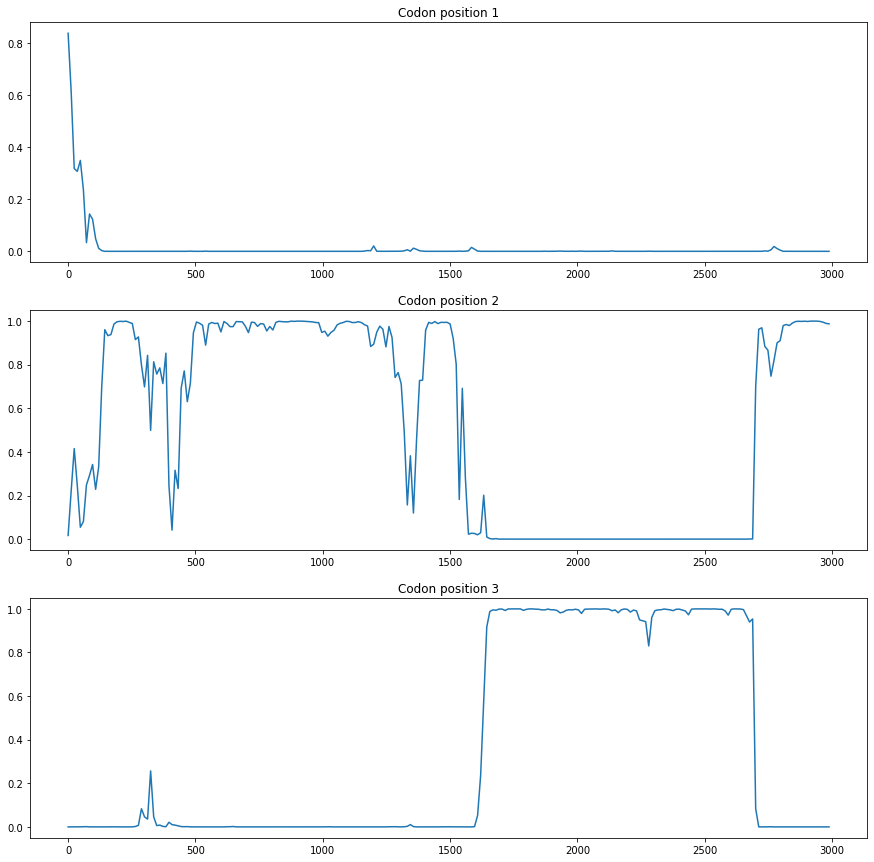

In [23]:
def plot_graph(data, start, end, step):
  fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

  x = range(start, end, step)

  ax1.plot(x, data[:, 0])
  ax2.plot(x, data[:, 1])
  ax3.plot(x, data[:, 2])

  ax1.set_title('Codon position 1')
  ax2.set_title('Codon position 2')
  ax3.set_title('Codon position 3')

  plt.plot()


start = 0
end = 3000
step = 12
window = 96
pos_probs = []
for i in range(start, end, step):

  pos_probs.append(get_cod_probs(seq[start+i:start+window+i], t1, t2))
pos_probs = np.array(pos_probs)

plot_graph(pos_probs, start, end, step)